**Unstructured Data Analytics: Group Assignment #1**

# Group Members:
1. Rithu Anand Krishnan
2. Manvi Mahajan
3. Paul Wen (Yilin Wen)
4. Alex Yu
5. Judy Chen (Yu-Ting Chen)

In [ ]:
## Imports
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as p
from statistics import mean
from sklearn.manifold import MDS
import sklearn.datasets as dt
import seaborn as sns
from nltk import pos_tag
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.linear_model import LinearRegression
import os
import re
import nltk
import requests
import csv
import matplotlib
import matplotlib.pyplot as plt
import string
import math
nltk.download('all')

# Web Scraper

Code to Scrape the forum website.

In [ ]:
# We are scrapping 102 pages to get 5051 posts/comments
page = 1
comments = []
timevar = []
while page != 102:
      url = f"https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{page}"
      #print(url)
      response = requests.get(url)
      html = response.content
      soup = bs(html, "lxml")
      for h3 in soup.find_all("div", {"class": "Message userContent"}):
            comments.append(h3.get_text(strip=True))
      for i in soup.findAll('time'):
        if i.has_attr('title'):
            timevar.append(i['title'])
      page = page + 1
data_tuples = list(zip(timevar,comments))
#print(data_tuples)
df=pd.DataFrame(data_tuples, columns=['Time','Comments'])
df.to_csv('scrape.csv')


## Task A: 

Once you fetch the data, test if the data support Zipf’s law econometrically. Also plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

In [ ]:
#Created comments dataframe from scarped information and performing basic cleaning like removing punctuations
comments = pd.read_csv("scrape.csv", names=["id", "time", "comments"])
comments['comments'] = comments['comments'].str.replace('[{}]'.format(string.punctuation), '')

#Check if any comments row have NaN values, if yes then remove them
#comments[comments.isnull().any(axis=1)].head()
clean_comments = comments.dropna(how='any')

all_words = clean_comments["comments"].sum()
words = nltk.tokenize.word_tokenize(all_words)
#Finding the frequency of all words including stopwords
fdist = FreqDist(words)

word_freq_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


      rank    word  frequency  zipf_value  log_rank   log_freq       xreg
30       1     the      24136   17.000000  0.000000  10.091460 -10.934891
6        2       a      11672    8.500000  0.693147   9.364948 -10.241744
12       3     and       9985    5.666667  1.098612   9.208839  -9.836279
21       4      to       9682    4.250000  1.386294   9.178024  -9.548597
215      5       I       8005    3.400000  1.609438   8.987822  -9.325453
...    ...     ...        ...         ...       ...        ...        ...
150     96    also        570    0.177083  4.564348   6.345636  -6.370543
24      97    well        568    0.175258  4.574711   6.342121  -6.360180
485     98     RWD        567    0.173469  4.584967   6.340359  -6.349924
271     99  engine        567    0.171717  4.595120   6.340359  -6.339771
1067   100      we        561    0.170000  4.605170   6.329721  -6.329721

[100 rows x 7 columns]


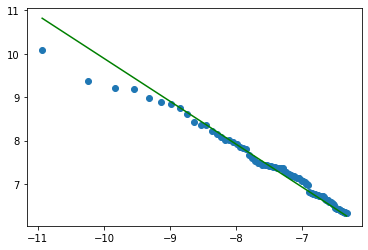

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.446e+05
Date:                Wed, 12 Oct 2022   Prob (F-statistic):                   8.98e-170
Time:                        23:55:13   Log-Likelihood:                          50.230
No. Observations:                 100   AIC:                                     -98.46
Df Residuals:                      99   BIC:                                     -95.86
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
#Calculation the Zipfs value for each word, running linear regression model and plotting the final results. 
import statsmodels.api as sm

pos = np.arange(100)
s = 1
expected_zipf = [word_freq_df.sort_values(by='frequency', ascending=False)['frequency'][0]/(i+1)**s for i in pos]

final_zipf_df = word_freq_df.sort_values(by='frequency', ascending=False).iloc[:100]
final_zipf_df['zipf_value'] = expected_zipf

final_zipf_df.insert(0, 'rank', range(1, len(final_zipf_df) + 1))
final_zipf_df["log_rank"] = final_zipf_df["rank"].map(lambda x: math.log(x))
final_zipf_df["log_freq"] = final_zipf_df["frequency"].map(lambda x: math.log(x))

eco_denominator = final_zipf_df.loc[final_zipf_df["frequency"].idxmin(), "frequency"] * final_zipf_df.shape[0]
final_zipf_df["xreg"] = final_zipf_df["rank"].map(lambda x: math.log(x/eco_denominator))

#Printing the contents of zipf dataframe
print(final_zipf_df)

X = final_zipf_df.loc[:, "xreg"].values.reshape(-1,1)
Y = final_zipf_df.loc[:, "log_freq"].values.reshape(-1,1)

result = sm.OLS(Y, X).fit()
Y_pred = result.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color="green")
plt.show()
print(result.summary())

In [ ]:
# From the summary we know that
# theta = -0.9894
# std err = 0.002
t = (-0.9894 + 1)/0.002
t

5.3000000000000265

As we can see the Theta value is "-0.9894" because we have picked the top 100 most frequent words, -0.98 is very close to -1. Our t value is 5.3 from the calculations above and after referring to the t table online , we can prove that our value of t is significant for 99 degrees of freedom.

# Task B
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file.   

In [ ]:
# RUN ME if you'd like to be able to output more than one variable value without using a print statement.
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.debugger import set_trace
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#saving the comment with stopwords in to a new dataframe.
sentence_with_stopwords = clean_comments['comments']

#sepearating by word and removing stop words
current_directory = os.getcwd()

if not os.path.isfile(current_directory + '/words_stop.csv') or not os.path.isfile(current_directory + '/words_no_stop.csv'):
    with_stop_words = []
    for idx, sentence in tqdm(sentence_with_stopwords.items()): ## items() to get the key value pairs index and sentences
        for word in list(set(sentence.split())):  ## set to get one word only once from a single comment
            word = re.sub(r'\W+', '', word) # removes all special characters
            with_stop_words.append(word.strip().lower()) # lower # strip removes any leading or trailing space character by default
           
    no_stop_words = []
    for word in tqdm(with_stop_words):
        if word.lower() not in stopwords.words('english'):
            no_stop_words.append(word.lower()) 
            
    words_withoutstopwords = pd.Series(no_stop_words)
    words_withstopwords = pd.Series(with_stop_words)
    
    s_words_tok = []
    for word in tqdm(words_withoutstopwords):
      tokenizer = nltk.RegexpTokenizer(r"\w+")
      try:
        new_word = tokenizer.tokenize(word)
        s_words_tok.append(new_word[0])
      except IndexError:
        pass
    
    words_withoutstopwords = pd.Series(s_words_tok)
    words_withstopwords.to_csv('words_stop.csv', index=False)
    words_withoutstopwords.to_csv('words_no_stop.csv', index=False)
else:
    print('Words have already been processed, loading now...')
    words_withstopwords = pd.read_csv('words_stop.csv')['0']
    words_withoutstopwords = pd.read_csv('words_no_stop.csv')['0']

4987it [00:00, 5261.14it/s]
100%|██████████| 209004/209004 [00:01<00:00, 206977.55it/s]


In [ ]:
top_word = words_withoutstopwords.value_counts().index.to_list()[0]
top_frequency = words_withoutstopwords.value_counts().iloc[0]
print('The word with the highest frequency is "%s": %d'%(top_word, top_frequency))

The word with the highest frequency is "car": 1977


In [ ]:
#Replacing card model names with actual card brand names
car_models = pd.read_csv('car models and brands.csv')
model_list = car_models['Model'].to_list()

#check if word is in card_model array and changes it the brand
def brand_changer(words):
    newlist = []
    for word in words:
        if word in model_list:
          #if word in model array change it to the corresponding brand
            newlist.append(car_models[car_models['Model']==word]['Brand'].values[0])
        else:
            newlist.append(word)
            
    return newlist

#make brand into dictionary with initial value as 0
brands = list(car_models['Brand'].unique())

## Removing some noise from the data
for i in ['car','problem','sedan','seat']:
  brands.remove(i)

#counts frequency of each brand, returns array of tupples with top 10 brands: [(brand, frequency),(brand,frequncy),...etc]
def brand_freq(words):
    brand_count = dict.fromkeys(brands, 0)
    
    for word in words:
        if word in list(brand_count.keys()):
            brand_count[word] +=1
    
    return sorted(brand_count.items(),  key=lambda x: x[1], reverse=True)[:11]

words_brand_filtered = pd.Series(brand_changer(words_withoutstopwords.to_list()))
sorted_brand_freq = pd.Series(brand_freq(words_brand_filtered.to_list()))

In [ ]:
sorted_brand_freq.to_csv('brand_freq.csv', index=False)
print("List of most 10 most frequent brands are")
sorted_brand_freq

List of most 10 most frequent brands are


0           (bmw, 1631)
1          (acura, 610)
2           (audi, 571)
3          (honda, 502)
4       (infiniti, 379)
5         (nissan, 379)
6         (toyota, 334)
7         (subaru, 269)
8     (volkswagen, 228)
9           (ford, 158)
10         (volvo, 141)
dtype: object

# Task C
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

In [ ]:
#takes out top 10 brands from tuple in sorted brand freq
brands = [ item[0] for item in sorted_brand_freq]

# finds lift between two entities
def lift(A, B, messages):
    A=A.lower()
    B=B.lower()
    A_count = 0
    B_count = 0
    AB_count = 0
    n=len(messages)
    for message in messages:
      message=message.lower()
      if A in message:
        A_count+=1
      if B in message:
        B_count+=1
      if A in message and B in message:
        AB_count+=1
    lift_val= (n*AB_count)/(A_count*B_count)
    if A == B:
      return 1
    else:
      return round(lift_val,4)

# utilizes lift function above and runs agaainst all the brands in the brand list. 
# Returns dataframe of lift values with useless values removed
def lift_everything(brands,messages):
  results=[]
  counter=0
  for b in brands:
    results.append([])
    for f in brands:
      k=lift(b,f,messages)
      results[counter].append(k)
    counter+=1
  import numpy as np
  triangle = np.triu (results)
  import pandas as pd
  return pd.DataFrame(triangle, columns=[brands], index=[brands])

In [ ]:
#made array with all the messsages with brand 
messages_with_brands = []
for message in tqdm(sentence_with_stopwords):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  message_tok = tokenizer.tokenize(message)
  words = " ".join(message_tok).lower().split()
  messages_with_brands.append(" ".join(brand_changer(words)))

100%|██████████| 4987/4987 [00:08<00:00, 556.87it/s]


In [ ]:
lift_matrix = lift_everything(brands,messages_with_brands)
lift_matrix_full = np.maximum( lift_matrix, lift_matrix.transpose())
lift_matrix_full

,bmw,acura,audi,honda,infiniti,nissan,toyota,subaru,volkswagen,ford,volvo
bmw,1.0000,1.5674,1.7931,1.2278,2.0549,1.2399,1.4161,1.1969,1.5152,1.5193,1.5967
acura,1.5674,1.0000,2.0910,2.7287,3.0591,2.2153,1.8066,2.0618,1.8302,1.6380,3.2192
audi,1.7931,2.0910,1.0000,1.2702,2.5262,1.3756,1.1424,1.8478,4.2529,1.7349,4.0942
honda,1.2278,2.7287,1.2702,1.0000,1.6168,4.0245,4.0897,1.5716,2.5015,2.2897,2.2815
infiniti,2.0549,3.0591,2.5262,1.6168,1.0000,2.9827,1.2247,1.7757,2.0895,1.7193,2.6698
nissan,1.2399,2.2153,1.3756,4.0245,2.9827,1.0000,4.0740,1.6023,2.6878,1.7193,3.5562
toyota,1.4161,1.8066,1.1424,4.0897,1.2247,4.0740,1.0000,1.4593,2.3324,2.0912,2.4250
subaru,1.1969,2.0618,1.8478,1.5716,1.7757,1.6023,1.4593,1.0000,2.4899,1.7219,4.5417
volkswagen,1.5152,1.8302,4.2529,2.5015,2.0895,2.6878,2.3324,2.4899,1.0000,2.2146,3.1525
ford,1.5193,1.6380,1.7349,2.2897,1.7193,1.7193,2.0912,1.7219,2.2146,1.0000,3.6549


##Task D: 
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Text(-20, 20, 'bmw')

Text(-20, 20, 'acura')

Text(-20, 20, 'audi')

Text(-20, 20, 'honda')

Text(-20, 20, 'infiniti')

Text(-20, 20, 'nissan')

Text(-20, 20, 'toyota')

Text(-20, 20, 'subaru')

Text(-20, 20, 'volkswagen')

Text(-20, 20, 'ford')

Text(-20, 20, 'volvo')

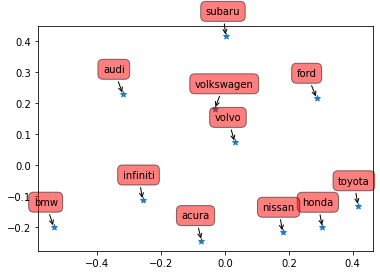

In [ ]:
## Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/lift_matrix_full
np.fill_diagonal(dissimilarity_matrix.values, 0)

## Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_


plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = '*'
    )
for label, x, y in zip(brands, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points',ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

# Task E: 
What insights can you offer to your client from your analyses in Tasks C and D 

# Answer

Subaru-Volvo
Subaru has been working on its safety feature recently, and we know that Volvo is often associated with safety. So we can derive that the lift value of 4.5 between these two brands emphasises this. Here is an article that talks about Subaru's new safety features. https://www.caranddriver.com/news/a37456933/2022-subaru-forester-revealed-specs-details


Honda-Toyota-Nissan 
All of these brands have over 4.0 lift values with each other. They all seem to occupy and compete for the same slice of the market. They all have the same price range and are all very reliable cars. College students enjoy these cars for both their reliability and relatively lower prices. 


BMW
We see that the lift value of BMW with other brands is relatively around the range of 1-2, this goes to show that BMW as a brand is often compared less with other cars when compared to the other brands in the list. This could mean that owners of BMW do not intend to change to other brands as easily.



# Task F: 

What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [ ]:
#Read the respective files 
colnames = ['id','date','comments']
df = pd.read_csv(r'scrape.csv', sep=',', names = colnames)

model_brand = pd.read_csv('car models and brands.csv', header = None)
model_brand.columns = ['brand','model']
model_brand_dict = model_brand["brand"].to_dict()

stop = stopwords.words('english')
df['comments'] = df['comments'].astype(str)
df['comments_tokens'] = df['comments'].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
df['comments_tokens'] = df['comments_tokens'].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
df['comments_tokens'] = df['comments_tokens'].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
df['comments_unique'] = df['comments_tokens'].apply(lambda x: sorted(set(x)))

# POS Tagging
df['pos']=df['comments_unique'].apply(nltk.tag.pos_tag)

# Filter adjectives
df['adjectives']=df['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].endswith('JJ')])
df.head()

,id,date,comments,comments_tokens,comments_unique,pos,adjectives
0,NaN,Time,Comments,[comments],[comments],"[(comments, NNS)]",[]
1,0.0,"March 23, 2002 12:04PM",Entry level performance luxury sedans are a ho...,"[entry, level, performance, luxury, sedans, ho...","[0, 3, 30, 300m, 330, 40k, 60, a4, acura, addi...","[(0, CD), (3, CD), (30, CD), (300m, CD), (330,...","[available, common, define, es300, evaluate, g..."
2,1.0,"March 24, 2002 10:54PM",I personally think that with a few tweaks the ...,"[personally, think, tweaks, c320, could, also,...","[0, 10, 17, 2002, 2003, 255hp, 3, 300m, 330i, ...","[(0, CD), (10, CD), (17, CD), (2002, CD), (200...","[accpetable, american, audi, awful, believe, b..."
3,2.0,"March 25, 2002 12:06AM",I am debating a new purchase and these two are...,"[debating, new, purchase, two, top, list, pric...","[2002, 6k, acura, appreciate, approx, better, ...","[(2002, CD), (6k, CD), (acura, NN), (appreciat...","[familiar, great, initial, lexus, new, overall..."
4,3.0,"March 25, 2002 10:02AM","Great handling, RWD, excellent engine and the ...","[great, handling, rwd, excellent, engine, best...","[around, best, easy, engine, excellent, great,...","[(around, RB), (best, JJS), (easy, JJ), (engin...","[easy, excellent, great, rwd]"


In [ ]:
feature = ['comfortable', 'safety', 'security', 'style', 'fashionable', 'color', 'luxury', 'price', 'affordable', 'speed', 'performance', 'consumption', 'maintainence', 'capacity']
df_feature = pd.DataFrame(feature, columns = ['feature'])

dict_feature = df_feature["feature"].to_dict()
df["features_tokens"] = df["comments_unique"].apply(lambda list_of_words: [dict_feature[x] for x in list_of_words if x in dict_feature])

# Get top 5 brands to find the attributes that are most associated with
top_brand = brands[0:5]

# Get frequency of features
unique_feature = np.unique(df_feature['feature'])

def freq(tokenized_df,find_list):
    freq_feature = 0
    for i in tokenized_df:
        if find_list in i:
            freq_feature += 1
    return freq_feature
  
df_top_features = pd.DataFrame(columns=['feature','freq'])
for i,feature in enumerate(unique_feature):
        temp_freq = freq(df.comments_unique,str(feature))
        df_top_features.loc[i]=[str(feature),temp_freq]
        
top_features = df_top_features.sort_values(by='freq',ascending=False).head(5)

# Calculate Lift value
def calculate_lift(a, b, tokenized_posts):
    num_a = 0
    num_b = 0
    num_a_b = 0
    n = len(tokenized_posts)
    if a==b:
        return 1
    for i in tokenized_posts:
        if a in i:
            num_a += 1
        if b in i:
            num_b += 1
        if a in i and b in i:
            num_a_b += 1
    if num_a == 0:
        return (float(n)*num_a_b)/(num_b)
    elif num_b == 0:
        return (float(n)*num_a_b)/(num_a)
    else:
        return (float(n)*num_a_b)/(num_a*num_b)

# Lift: features and brands
lift_feature_brand = pd.DataFrame(columns = ['brand','feature','lift'])
i=0
for  brand_a in top_brand:
    for feature in top_features['feature']:
        temp_lift=calculate_lift(str(brand_a), str(feature), df.comments_unique)
        lift_feature_brand.loc[i]=[str(brand_a),str(feature),temp_lift]
        i=i+1
        
df_lift = lift_feature_brand.sort_values('lift',ascending = False).groupby('brand').head(10)

# Print the lift matrix
lift_matrix2 = df_lift.pivot(index='brand', columns='feature')
lift_matrix2

lift                                          
feature     luxury performance     price     speed     style
brand                                                       
acura     2.243793    1.694523  1.633628  1.492233  1.623175
audi      1.620081    1.674254  2.074337  1.553510  2.884868
bmw       1.471911    1.557244  1.625949  1.298447  1.735214
honda     2.050681    1.201938  1.530600  1.508671  2.171243
infiniti  1.795668    1.660705  1.681006  1.077000  1.788451

#Task G: 
What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive. 

# Answer
**Acura**
Acura is the highest amongst the top 5 brands for Luxury with a lift value of 2.24 . They are perceived as having the most comfortable features. However, In the other four categories, it is regarded as being about average. They should concentrate on enhancing style as it is the weakest among the other four with a value of 1.6, which would help them draw in more clients who would purchase their products because of their luxurious characteristics. Our advice is for their design team to look into making the next Acuras more stylish and how to make the upcoming Acuras more fashionable and test several ideas to see how people react.

**BMW** It is bizarre that BMW did not stand high on the luxury lift column; despite being a luxury car brand. We could interpret this as the fact that it is a given that BMW doesn't need extra mentions about its luxury. Association between BWM and speed seems to be low too with a value of 1.2. Therefore, our advice would be for the Engineering team to target the weakest link - speed or for the marketing team to focus on increasing the spotlight on the speed aspect. 

**Honda**
With highest luxury (2.05) and style (2.19) lift values among all the other brands on our list makes Honda seem very intriguing. The lift value for the price can likely be interpreted as being very affordable. On the other hand, given that luxury is one of the highest, it might be thought to offer outstanding luxury at a reasonable cost. They have been rebranding themselves. Therefore this might indicate that their marketing strategies are working. "Performance" is weaker for Honda, with a lift value of 1.2, the smallest lift value with Performance compared to the other top 4 brands. Speed and Performance are often compared to mileage and power. Our advice to Honda would be to ask them to continue what they are doing because it seems to be working for them, and enhancements under the performance category would be a bonus.

**Audi** In the Style category, Audi is at the top with a lift value of 2.88. It is quite alluring to those who want a car that looks exceptionally fantastic. However, as evidenced by the highest price lift value, this has the highest price point (assuming a high lift in price is the highest price). This is consistent with what most people know about the costs of Audis. Additionally, They also have the highest speed and perform decently in all other categories. Our advice for Audi would be to try and lower their price a little to make the entry point for a brand with decent to best-in-class features a little more appealing.

**Infiniti**
Infiniti holds a steady lift of 1.7 - 1.6 with almost all five attributes. This shows that their cars are just average in any of these features, not giving them a chance to stand out in any particular categories. The speed value of Infiniti is the worst of all other car features on the matrix, with a value of just 1.06. We could advise the engineering team of Infiniti to look into designs that would allow the vehicles to be more aerodynamic and have better horsepower, increasing consumer satisfaction in the speed category.


#Task H: 
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [ ]:
# Create a list of all the aspirational phrases or words list, to replace the comments containing these texts with "aspiration"
aspirational_words = ['hope that', 'hope to', 'wish to', 'wish that', 'dream to', 'dream that', 'would like', 'would love', 'aim', 'plan to', 'need to', 'needs to']
aspiration = pd.DataFrame(aspirational_words)
aspiration.columns=['phrases']
aspiration_list = aspiration['phrases'].to_list()

for i in aspirational_words:
    df['comments_aspiration'] = df['comments'].str.replace(i,"aspiration")

df['comments_tokens'] = df['comments_aspiration'].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
df['comments_tokens'] = df['comments_tokens'].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
df['comments_tokens'] = df['comments_tokens'].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
df['comments_unique'] = df['comments_tokens'].apply(lambda x: sorted(set(x)))
# Lift: features and brands
lift_aspiration_brand = pd.DataFrame(columns = ['brand','feature','lift'])
i=0
for brand in brands:
    temp_lift=calculate_lift(str(brand), df.comments_unique.contains('aspiratio'), df.comments_unique)
    lift_aspiration_brand.loc[i]=[str(brand),str(df.comments_unique).contains('aspiratio'),temp_lift]
    i=i+1

lift_aspiration_brand.sort_values('lift',ascending = False).head(10)

# Answer
Even if Volvo is occasionally mentioned, it always has a highly positive connotation. The folks who have invested in Volvo are highly optimistic about their potential. Volvo needs to be careful not to squander this opportunity and work to live up to the high expectations with its aspirations to make a significant entry into the electric vehicle industry. Current Volvo supporters' aspirations to compete with Tesla as a premium electric car maker are pretty exciting. Volvo will need to ensure they are competitive in those two areas to take advantage of this potential because people are concerned with the performance of electric cars in terms of both efficiencies compared to ordinary automobiles and pricing.